Mount drive, then change to working directory.


In [0]:
%tensorflow_version 1.x
from google.colab import drive
drive.mount('/content/drive')
%cd drive/My Drive/MIR

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
[Errno 2] No such file or directory: 'drive/My Drive/MIR'
/content/drive/My Drive/MIR


Load pre-computed feature sets from the three datasets of English, Chinese and Turkish music, both train and test.

In [0]:
import pandas as pd

E_train_data_file = 'MER_audio_taffc_dataset/train_segments/train_data.csv'
C_train_data_file = 'CH-818/ch818_mp3/train_segments/train_data.csv'
T_train_data_file = 'tr-music-dataset/train_segments/train_data.csv'

E_test_data_file = 'MER_audio_taffc_dataset/test_segments/test_data.csv'
C_test_data_file = 'CH-818/ch818_mp3/test_segments/test_data.csv'
T_test_data_file = 'tr-music-dataset/test_segments/test_data.csv'

E_train_data = pd.read_csv(E_train_data_file)
C_train_data = pd.read_csv(C_train_data_file)
T_train_data = pd.read_csv(T_train_data_file)

E_test_data = pd.read_csv(E_test_data_file)
C_test_data = pd.read_csv(C_test_data_file)
T_test_data = pd.read_csv(T_test_data_file)

Normalize features.

In [0]:
from sklearn import preprocessing
min_max_scaler = preprocessing.MinMaxScaler()

E_train_data_modif = E_train_data.copy()
C_train_data_modif = C_train_data.copy()
T_train_data_modif = T_train_data.copy()

E_test_data_modif = E_test_data.copy()
C_test_data_modif = C_test_data.copy()
T_test_data_modif = T_test_data.copy()

E_train_data_modif.iloc[:,:84] = min_max_scaler.fit_transform(E_train_data.iloc[:,:84].values)
C_train_data_modif.iloc[:,:84] = min_max_scaler.fit_transform(C_train_data.iloc[:,:84].values)
T_train_data_modif.iloc[:,:84] = min_max_scaler.fit_transform(T_train_data.iloc[:,:84].values)

E_test_data_modif.iloc[:,:84] = min_max_scaler.fit_transform(E_test_data.iloc[:,:84].values)
C_test_data_modif.iloc[:,:84] = min_max_scaler.fit_transform(C_test_data.iloc[:,:84].values)
T_test_data_modif.iloc[:,:84] = min_max_scaler.fit_transform(T_test_data.iloc[:,:84].values)

Balance training datasets

In [40]:
# Balancing data
def balance(data_modif, q):
    min_number = data_modif.emotion.value_counts()[q]
    q1_data = data_modif[data_modif.emotion == 'q1'].sample(n = min_number, random_state = 42)
    q2_data = data_modif[data_modif.emotion == 'q2'].sample(n = min_number, random_state = 42)
    q3_data = data_modif[data_modif.emotion == 'q3'].sample(n = min_number, random_state = 42)
    q4_data = data_modif[data_modif.emotion == 'q4'].sample(n = min_number, random_state = 42)
    return pd.concat([q1_data, q2_data, q3_data, q4_data])

E_train_data_modif = balance(E_train_data_modif, 'q2') #q2 had the fewest samples
C_train_data_modif = balance(C_train_data_modif, 'q3')
T_train_data_modif = balance(T_train_data_modif, 'q2')

print(E_train_data_modif.emotion.value_counts())
print(C_train_data_modif.emotion.value_counts())
print(T_train_data_modif.emotion.value_counts())

q4    708
q3    708
q2    708
q1    708
Name: emotion, dtype: int64
q4    264
q3    264
q2    264
q1    264
Name: emotion, dtype: int64
q4    296
q3    296
q2    296
q1    296
Name: emotion, dtype: int64


Prepare data arrays for features and labels.

In [53]:
import numpy as np

#Input values put in a matrix, there are 84 features
E_train_X = E_train_data_modif.iloc[:,:84].values 
C_train_X = C_train_data_modif.iloc[:,:84].values 
T_train_X = T_train_data_modif.iloc[:,:84].values 

E_test_X = E_test_data_modif.iloc[:,:84].values 
C_test_X = C_test_data_modif.iloc[:,:84].values 
T_test_X = T_test_data_modif.iloc[:,:84].values 

#Output values
E_train_data_modif.emotion = pd.Categorical(E_train_data_modif.emotion) #convert to categorical data
C_train_data_modif.emotion = pd.Categorical(C_train_data_modif.emotion)
T_train_data_modif.emotion = pd.Categorical(T_train_data_modif.emotion)

E_test_data_modif.emotion = pd.Categorical(E_test_data_modif.emotion) 
C_test_data_modif.emotion = pd.Categorical(C_test_data_modif.emotion)
T_test_data_modif.emotion = pd.Categorical(T_test_data_modif.emotion) 

E_train_y = np.array(E_train_data_modif.emotion.cat.codes) #create label encoded outputs
C_train_y = np.array(C_train_data_modif.emotion.cat.codes) 
T_train_y = np.array(T_train_data_modif.emotion.cat.codes) 

E_test_y = np.array(E_test_data_modif.emotion.cat.codes)
C_test_y = np.array(C_test_data_modif.emotion.cat.codes) 
T_test_y = np.array(T_test_data_modif.emotion.cat.codes) 

print('E_X_train shape is ', E_train_X.shape)
print('E_X_test shape is ', E_test_X.shape, '\n')
print('C_X_train shape is ', C_train_X.shape)
print('C_X_test shape is ', C_test_X.shape, '\n')
print('T_X_train shape is ', T_train_X.shape)
print('T_X_test shape is ', T_test_X.shape)

E_X_train shape is  (2832, 84)
E_X_test shape is  (720, 84) 

C_X_train shape is  (1056, 84)
C_X_test shape is  (288, 84) 

T_X_train shape is  (1184, 84)
T_X_test shape is  (320, 84)


Prepare X and y arrays for the mixed training data experiments

In [54]:
X_train = []
y_train = []

def append(c, i, X, y):
    c += 1
    X_train.append(X[i])
    y_train.append(y[i])
    return c

def add_for_set(X, y):
    c1 = 0; c2 = 0; c3 = 0; c4 = 0
    for i, emotion in enumerate(y): 
        if emotion == 0 and c1 < 264:
            c1 = append(c1, i, X, y)
        elif emotion == 1 and c2 < 264:
            c2 = append(c2, i, X, y)
        elif emotion == 2 and c3 < 264:
            c3 = append(c3, i, X, y)
        elif emotion == 3 and c4 < 264:
            c4 = append(c4, i, X, y)

add_for_set(E_train_X, E_train_y)
add_for_set(C_train_X, C_train_y)
add_for_set(T_train_X, T_train_y)

EX_test = E_test_X
CX_test = C_test_X
TX_test = T_test_X
Ey_test = E_test_y
Cy_test = C_test_y
Ty_test = T_test_y

print('X_train length is ', len(X_train))
print('y_train length is ', len(y_train))

X_train length is  3168
y_train length is  3168


Feature selection by selecting the best k features for k = 50 out of the 84 total features

In [0]:
from sklearn.feature_selection import SelectKBest, chi2

fit_E = SelectKBest(chi2, k=50).fit(E_train_X, E_train_y)
fit_C = SelectKBest(chi2, k=50).fit(C_train_X, C_train_y)
fit_T = SelectKBest(chi2, k=50).fit(T_train_X, T_train_y)

E_train_X = fit_E.transform(E_train_X)
C_train_X = fit_C.transform(C_train_X)
T_train_X = fit_T.transform(T_train_X)

Feature selection for the mixed training data experiments

In [56]:
from sklearn.utils import shuffle
X_train, y_train = shuffle(X_train, y_train, random_state=13)
fit = SelectKBest(chi2, k=50).fit(X_train, y_train)

X_train = fit.transform(X_train)
EX_test = fit.transform(EX_test) 
CX_test = fit.transform(CX_test) 
TX_test = fit.transform(TX_test)   

print('Top 10 selected features: ')
ten = fit.scores_.argsort()[-10:][::-1] # 10 best features selected 
for i in ten:
    print(E_train_data_modif.keys()[i])

Top 10 selected features: 
spectral_complexity.mean
spectral_complexity.stdev
spectral_centroid.mean
barkbands_spread.mean
spectral_energyband_high.mean
spectral_skewness.stdev
zerocrossingrate.mean
silence_rate_30dB.stdev
melbands_spread.mean
spectral_flux.mean


Train on source dataset & Test on target dataset (3 x 3 experiments) - Best classifier for SOURCE data

In [45]:
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score

train_sets = [[E_train_X, E_train_y], [C_train_X, C_train_y], [T_train_X, T_train_y]]
test_sets = [[E_test_X, E_test_y], [C_test_X, C_test_y], [T_test_X, T_test_y]]
for i, train in enumerate(train_sets):
    for j, test in enumerate(test_sets):
        model = RandomForestClassifier(max_depth=15, random_state=0) if i==0 else KNeighborsClassifier(7) if i==1 else MLPClassifier(alpha=1, max_iter=1000)
        model.fit(train[0], train[1])
        var = test[0]
        var = fit_E.transform(var) if i==0 else fit_C.transform(var) if i==1 else fit_T.transform(var)  # apply features used in the training dataset
        y_pred = model.predict(var)
        y_test = test[1]  
        tr = 'English' if i==0 else 'Chinese' if i==1 else 'Turkish'
        te = 'English' if j==0 else 'Chinese' if j==1 else 'Turkish'
        print('Train: ', tr, ' & Test: ', te)   
        print(round(accuracy_score(y_test, y_pred), 2)) 
        #print(classification_report(y_test, y_pred))

Train:  English  & Test:  English
0.57
Train:  English  & Test:  Chinese
0.27
Train:  English  & Test:  Turkish
0.42
Train:  Chinese  & Test:  English
0.3
Train:  Chinese  & Test:  Chinese
0.32
Train:  Chinese  & Test:  Turkish
0.23
Train:  Turkish  & Test:  English
0.52
Train:  Turkish  & Test:  Chinese
0.29
Train:  Turkish  & Test:  Turkish
0.7


Define model for Deep Learning model.

In [0]:
from keras.models import Sequential
from keras import layers
def compose_model(num_features):
    
    model = Sequential()

    # Input layer 
    model.add(layers.BatchNormalization(name='InputLayer', input_shape=(num_features,)))
    
    # 1. hidden layer
    model.add(layers.Dense(name='HiddenLayer_1', units = 40))
    model.add(layers.BatchNormalization())
    model.add(layers.Activation('tanh'))
    model.add(layers.Dropout(0.3))

    # 2. hidden layyer
    model.add(layers.Dense(name='HiddenLayer_2', units = 20))
    model.add(layers.BatchNormalization())
    model.add(layers.Activation('relu'))
    model.add(layers.Dropout(0.3))

    # Output layer
    model.add(layers.Dense(name='Output_layer', units = 4))
    model.add(layers.Activation('sigmoid'))
    
    return model

Train on source dataset & Test on target dataset (3 x 3 experiments) - Deep Learning Classifier

In [47]:
from sklearn.utils import shuffle
from sklearn.preprocessing import OneHotEncoder

onehot_encoder = OneHotEncoder(sparse=False)
for train in train_sets:
    train[0], train[1] = shuffle(train[0], train[1], random_state=13)
    train[1] = onehot_encoder.fit_transform(train[1].reshape(len(train[1]), 1))

for i, train in enumerate(train_sets):
    for j, test in enumerate(test_sets):
        model = compose_model(train[0].shape[1])
        model.compile(optimizer = 'Adam', loss = 'binary_crossentropy', metrics = ['accuracy'])
        model.fit(train[0], train[1], batch_size = 50, epochs = 300, validation_split=0.2, verbose=0,)
        var = test[0]
        var = fit_E.transform(var) if i==0 else fit_C.transform(var) if i==1 else fit_T.transform(var)  # apply features used in the training dataset
        y_pred = model.predict_classes(var)
        y_test = test[1]
        tr = 'English' if i==0 else 'Chinese' if i==1 else 'Turkish'
        te = 'English' if j==0 else 'Chinese' if j==1 else 'Turkish'
        print('Train: ', tr, ' & Test: ', te)   
        print(round(accuracy_score(y_test, y_pred), 2)) 
        #print(classification_report(y_test, y_pred))

Train:  English  & Test:  English
0.5
Train:  English  & Test:  Chinese
0.24
Train:  English  & Test:  Turkish
0.42
Train:  Chinese  & Test:  English
0.21
Train:  Chinese  & Test:  Chinese
0.24
Train:  Chinese  & Test:  Turkish
0.28
Train:  Turkish  & Test:  English
0.52
Train:  Turkish  & Test:  Chinese
0.29
Train:  Turkish  & Test:  Turkish
0.55


Train on FULL dataset & Test on target datasets (1 x 3 experiments) - Random Forest Classifier

Number of test samples:  720
              precision    recall  f1-score   support

           0       0.53      0.53      0.53       184
           1       0.84      0.66      0.74       192
           2       0.42      0.34      0.38       184
           3       0.43      0.65      0.52       160

    accuracy                           0.54       720
   macro avg       0.56      0.54      0.54       720
weighted avg       0.56      0.54      0.54       720

Confusion matrix: 



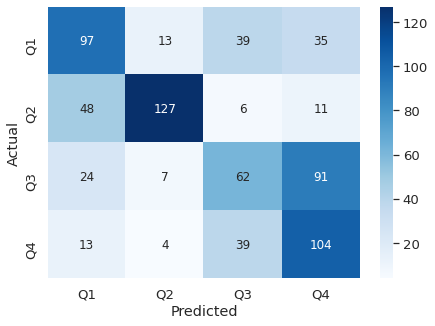

In [57]:
# Test on English
X_test = EX_test
y_test = Ey_test
from sklearn.ensemble import RandomForestClassifier
selected_model = RandomForestClassifier(max_depth=15, random_state=0)
selected_model.fit(X_train,y_train)
y_pred = selected_model.predict(X_test)
print("Number of test samples: ", len(y_pred))

from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

# Confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
print("Confusion matrix: \n")
classes = ['Q1', 'Q2', 'Q3', 'Q4']
conf_mat = pd.DataFrame(confusion_matrix(y_test, y_pred), columns = classes, index = classes)
conf_mat.index.name = 'Actual'
conf_mat.columns.name = 'Predicted'
plt.figure(figsize = (7, 5))
sns.set(font_scale = 1.2)
sns.heatmap(conf_mat, cmap = "Blues", annot_kws = {"size": 12}, annot = True, fmt="d");

Number of test samples:  288
              precision    recall  f1-score   support

           0       0.34      0.40      0.37        52
           1       0.21      0.15      0.18        72
           2       0.38      0.15      0.22        92
           3       0.28      0.53      0.37        72

    accuracy                           0.29       288
   macro avg       0.30      0.31      0.28       288
weighted avg       0.30      0.29      0.27       288

Confusion matrix: 



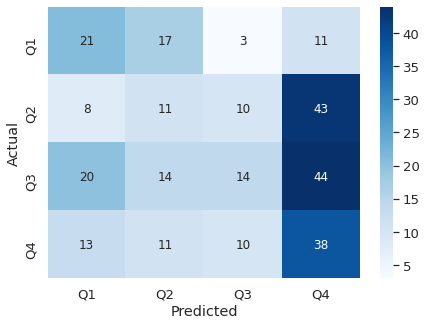

In [58]:
# Test on Chinese
X_test = CX_test
y_test = Cy_test
from sklearn.ensemble import RandomForestClassifier
selected_model = RandomForestClassifier(max_depth=15, random_state=0)
selected_model.fit(X_train,y_train)
y_pred = selected_model.predict(X_test)
print("Number of test samples: ", len(y_pred))

from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

# Confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
print("Confusion matrix: \n")
classes = ['Q1', 'Q2', 'Q3', 'Q4']
conf_mat = pd.DataFrame(confusion_matrix(y_test, y_pred), columns = classes, index = classes)
conf_mat.index.name = 'Actual'
conf_mat.columns.name = 'Predicted'
plt.figure(figsize = (7, 5))
sns.set(font_scale = 1.2)
sns.heatmap(conf_mat, cmap = "Blues", annot_kws = {"size": 12}, annot = True, fmt="d");

Number of test samples:  320
              precision    recall  f1-score   support

           0       0.60      0.74      0.66        72
           1       0.83      0.72      0.77       104
           2       0.51      0.31      0.38        72
           3       0.57      0.78      0.65        72

    accuracy                           0.64       320
   macro avg       0.63      0.64      0.62       320
weighted avg       0.65      0.64      0.63       320

Confusion matrix: 



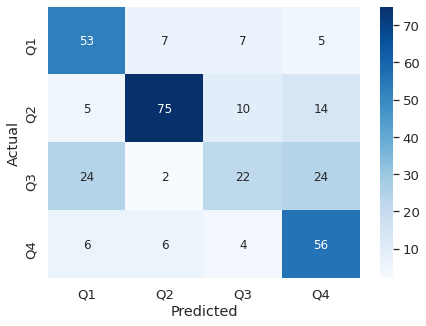

In [59]:
# Test on Turkish
X_test = TX_test
y_test = Ty_test
from sklearn.ensemble import RandomForestClassifier
selected_model = RandomForestClassifier(max_depth=15, random_state=0)
selected_model.fit(X_train,y_train)
y_pred = selected_model.predict(X_test)
print("Number of test samples: ", len(y_pred))

from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

# Confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
print("Confusion matrix: \n")
classes = ['Q1', 'Q2', 'Q3', 'Q4']
conf_mat = pd.DataFrame(confusion_matrix(y_test, y_pred), columns = classes, index = classes)
conf_mat.index.name = 'Actual'
conf_mat.columns.name = 'Predicted'
plt.figure(figsize = (7, 5))
sns.set(font_scale = 1.2)
sns.heatmap(conf_mat, cmap = "Blues", annot_kws = {"size": 12}, annot = True, fmt="d");